# Modelos Alternativos

**Proyecto Integrador TC5035.10**

**Profesor Asesor:**
- Dra. Ludivina Facundo (ITESM)


**Profesores Investigadores/Tutores:**
- Dr. Juan Arturo Nolazco (ITESM)
- Dr. Marcos Faunez Zaunuy (TecnoCampus Barcelona)

**Equipo 11:**
- Francisco José Arellano Montes (A01794283)
- Armando Bringas Corpus (A01200230)
- Moisés Díaz Malagón (A01208580)

**Objetivo**: Este avance implica construir múltiples modelos (individuales, no ensambles) relevantes para resolver el problema y evaluar su desempeño. Diferentes algoritmos pueden comportarse de manera óptima en diferentes tipos de datos o tareas. La construcción de modelos alternativos permite explorar y evaluar cuál de ellos proporciona el mejor rendimiento para un problema particular.

Además, los modelos se pueden ajustar para determinar si se puede mejorar su rendimiento. Diferentes configuraciones de hiperparámetros pueden afectar significativamente el rendimiento de un modelo. Construir modelos alternativos implica explorar y ajustar estos hiperparámetros para encontrar la configuración óptima.

In [1]:
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchview import draw_graph

from sklearn.metrics import (classification_report, roc_auc_score, precision_recall_curve,
                             auc, roc_curve, det_curve)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from utils import load_data, print_classification_report, plot_roc_det_curve

In [2]:
try:
    from sklearnex import patch_sklearn
    patch_sklearn()
except ImportError:
    pass

In [3]:
warnings.filterwarnings("ignore")

# Carga de Datos

Carga inicial de los datos:

Estos datos fueron procesados en la entrega pasada, usando los mismos pasos salvo a unos cuantas modificaciones necesarias para esta entrega.

Estos datos fueron nuevamente guardados en archivos .parquet que simplemente fueron cargados para facilitar su uso en futuras integraciones.

In [4]:
X_train, y_train, X_val, y_val, X_text, y_test = load_data()

In [5]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((571, 12), (571, 3), (556, 12), (556, 3))

# Métricas

Dado que se trabajará con un 3 problemas independientes de clasificación binaria, se utilizarán las siguientes métricas, Cada métrica ayuda a evaluar el desempeño de un modelo de diferentes maneras, especialmente para problemas de clasificación:

*   **accuracy:**


$$
\text{Accuracy} = \frac{\text{Correct Predictions}}{\text{Total Predictions}}
$$


Funciona bien cuando las clases están equilibradas (igual número de muestras en cada clase).

Ejemplo: en un modelo de detección de fraude en el que el 99 % de las transacciones son normales, un modelo que prediga "no fraude" el 100 % de las veces tendría una precisión del 99 % pero sería completamente inútil.

*   **precision:**

$$
\text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)}}
$$

Prioriza la reducción de Falsos Positivos (FP)

Ejemplo: la detección de spam, al marcar erróneamente un correo electrónico importante como spam es malo, lo cual da preferencia a falsos positivos.

*   **recall:**

$$
\text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}}
$$

Prioritizes reducing False Negatives (FN)

Ejemplo: detección de cáncer; Nos preocupamos por detectar todos los casos positivos reales, incluso si eso significa permitir más falsos positivos (FP).

*   **f1:**

$$
\text{F1} = \frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

Cuando necesita un equilibrio entre precisión y recall.

Ejemplo: detección de fraudes, se usan conjuntos de datos desequilibrados, donde las transacciones fraudulentas (positivas) son raras en comparación con las transacciones normales (negativas).


*   **roc_auc:**

Mide qué tan bien el modelo separa clases entre diferentes umbrales de probabilidad.

La curva ROC traza la tasa de verdaderos positivos (recuperación) frente a la tasa de falsos positivos (FPR).

# Algoritmos y entrenamiento

La detección de emociones a partir de datos textuales, como la base de datos EmoThaw, implica analizar datos no estructurados (contenido textual que carece de una estructura predefinida).

 Este tipo de datos a menudo requiere pasos de preprocesamiento como tokenización, derivación y vectorización para convertirlos en un formato estructurado adecuado para algoritmos de aprendizaje automático.

In [6]:
validation_data = {
    'svm': {},
    'xgboost': {},
    'lightgbm': {}, 
    'mlp': {},
    'cnn': {},
    'lstm': {}
}

## SVM (Support Vector Machine)

### Clasificador para Depresión

In [8]:
# Define the SVM model
svm_model = SVC(probability=True, class_weight='balanced', random_state=42)

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']  # Only relevant for RBF kernel
}

grid_search = GridSearchCV(
    svm_model, param_grid, scoring='roc_auc', cv=3, verbose=1
)

grid_search.fit(X_train, y_train['depression'])
best_svm_model = grid_search.best_estimator_

y_pred_svm = best_svm_model.predict(X_val)
y_prob_svm = best_svm_model.predict_proba(X_val)[:, 1]  # Probabilities for ROC/PR

print_classification_report(y_val['depression'], y_pred_svm, y_prob_svm, label="SVM Depression")
svm_depression_best_hyperparameters = grid_search.best_params_
print("Best hyperparameters:", svm_depression_best_hyperparameters)

validation_data['svm']['depression'] = {
    'y_val': y_val['depression'],
    'y_prob': y_prob_svm,
}

Fitting 3 folds for each of 12 candidates, totalling 36 fits
SVM Depression Classification Report:
              precision    recall  f1-score   support

       False       0.71      0.24      0.36       408
        True       0.26      0.73      0.38       148

    accuracy                           0.37       556
   macro avg       0.48      0.48      0.37       556
weighted avg       0.59      0.37      0.37       556

SVM Depression ROC AUC: 0.4882
SVM Depression Precision-Recall AUC: 0.2589
Best hyperparameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}


 Generamos nuestro modelo SVM, trabajando con nuestra etiqueta “depression” con un grid_search, al final tenemos una puntuación AUC de la curva ROC: 0.48

### Clasificador para Ansiedad

In [9]:
svm_model = SVC(probability=True, class_weight='balanced', random_state=42)

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']  # Only relevant for RBF kernel
}

grid_search = GridSearchCV(
    svm_model, param_grid, scoring='roc_auc', cv=5, verbose=1
)

grid_search.fit(X_train, y_train['anxiety'])
best_svm_model = grid_search.best_estimator_
y_pred_svm = best_svm_model.predict(X_val)
y_prob_svm = best_svm_model.predict_proba(X_val)[:, 1]  # Probabilities for ROC/PR

print_classification_report(y_val['anxiety'], y_pred_svm, y_prob_svm, label="SVM Anxiety")
svm_anxiety_best_hyperparameters = grid_search.best_params_
print("Best hyperparameters:", svm_anxiety_best_hyperparameters)

validation_data['svm']['anxiety'] = {
    'y_val': y_val['anxiety'],
    'y_prob': y_prob_svm,
}

Fitting 5 folds for each of 12 candidates, totalling 60 fits
SVM Anxiety Classification Report:
              precision    recall  f1-score   support

       False       0.57      0.94      0.71       317
        True       0.49      0.08      0.13       239

    accuracy                           0.57       556
   macro avg       0.53      0.51      0.42       556
weighted avg       0.54      0.57      0.46       556

SVM Anxiety ROC AUC: 0.4955
SVM Anxiety Precision-Recall AUC: 0.4326
Best hyperparameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}


### Clasificador para Estrés

In [10]:
svm_model = SVC(probability=True, class_weight='balanced', random_state=42)

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']  # Only relevant for RBF kernel
}

grid_search = GridSearchCV(
    svm_model, param_grid, scoring='roc_auc', cv=5, verbose=1
)

grid_search.fit(X_train, y_train['stress'])
best_svm_model = grid_search.best_estimator_
y_pred_svm = best_svm_model.predict(X_val)
y_prob_svm = best_svm_model.predict_proba(X_val)[:, 1]  # Probabilities for ROC/PR

print_classification_report(y_val['stress'], y_pred_svm, y_prob_svm, label="SVM Stress")
svm_stress_best_hyperparameters = grid_search.best_params_
print("Best hyperparameters:", svm_stress_best_hyperparameters)

validation_data['svm']['stress'] = {
    'y_val': y_val['stress'],
    'y_prob': y_prob_svm,
}

Fitting 5 folds for each of 12 candidates, totalling 60 fits
SVM Stress Classification Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       315
        True       0.43      1.00      0.60       241

    accuracy                           0.43       556
   macro avg       0.22      0.50      0.30       556
weighted avg       0.19      0.43      0.26       556

SVM Stress ROC AUC: 0.4952
SVM Stress Precision-Recall AUC: 0.4288
Best hyperparameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}


Observando la información anterior, podemos observar lo siguiente:
*   En el label de “depression”, tenemos una puntuación AUC de la curva ROC: 0.48
*   En el label de “anxiety”, tenemos una puntuación AUC de la curva ROC: 0.49
*   En el label de “stress”, tenemos una puntuación AUC de la curva ROC: 0.49

## XGBoost

### Clasificador para Depresión

In [11]:
# imbalance ratio
imbalance_ratio_depression = len(y_train['depression'][y_train['depression'] == 0]) / len(y_train['depression'][y_train['depression'] == 1])

In [12]:
# Initialize XGBoost with imbalance handling
xgb_model = XGBClassifier(scale_pos_weight=imbalance_ratio_depression, random_state=42)

# Train on depression classification
xgb_model.fit(X_train, y_train['depression'])

# Predict on validation set
y_pred_xgb = xgb_model.predict(X_val)
y_prob_xgb = xgb_model.predict_proba(X_val)[:, 1]

# Evaluate performance
print_classification_report(y_val['stress'], y_pred_xgb, y_prob_xgb, label="XGBoost Depression")

validation_data['xgboost']['stress'] = {
    'y_val': y_val['stress'],
    'y_prob': y_prob_xgb,
}

XGBoost Depression Classification Report:
              precision    recall  f1-score   support

       False       0.62      0.38      0.47       315
        True       0.46      0.69      0.55       241

    accuracy                           0.51       556
   macro avg       0.54      0.53      0.51       556
weighted avg       0.55      0.51      0.51       556

XGBoost Depression ROC AUC: 0.5525
XGBoost Depression Precision-Recall AUC: 0.5137


Generamos nuestro modelo clasificador xgb, obteniendo un relación de desequilibrio, trabajando con nuestra etiqueta “depression”, al final tenemos una puntuación AUC de la curva ROC: 0.50

In [14]:
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [3, 5, 7],  # Tree depth
    'learning_rate': [0.01, 0.1, 0.3],  # Step size
    'scale_pos_weight': [imbalance_ratio_depression]  # Imbalance handling
}

xgb_tuned = XGBClassifier(random_state=42)

grid_search = GridSearchCV(xgb_tuned, param_grid, scoring='roc_auc', cv=3, verbose=1)
grid_search.fit(X_train, y_train['depression'])

best_xgb = grid_search.best_estimator_

y_pred_xgb_tuned = best_xgb.predict(X_val)
y_prob_xgb_tuned = best_xgb.predict_proba(X_val)[:, 1]

print_classification_report(y_val['depression'], y_pred_xgb_tuned, y_prob_xgb_tuned, label="XGBoost Depression")
xgb_depression_best_hyperparameters = grid_search.best_params_
print("Best hyperparameters:", xgb_depression_best_hyperparameters)

validation_data['xgboost']['depression'] = {
    'y_val': y_val['depression'],
    'y_prob': y_prob_xgb_tuned,
}

Fitting 3 folds for each of 27 candidates, totalling 81 fits
XGBoost Depression Classification Report:
              precision    recall  f1-score   support

       False       0.79      0.04      0.07       408
        True       0.27      0.97      0.42       148

    accuracy                           0.29       556
   macro avg       0.53      0.50      0.25       556
weighted avg       0.65      0.29      0.16       556

XGBoost Depression ROC AUC: 0.5145
XGBoost Depression Precision-Recall AUC: 0.3261
Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 2.7320261437908497}


Similar al modelo anterior, ahora aplicando un grid_search y entrenando el mejor modelo tenemos al final tenemos una puntuación AUC de la curva ROC: 0.51

### Clasificador para Ansiedad

In [15]:
# imbalance ratio
imbalance_ratio_anxiety = len(y_train['anxiety'][y_train['anxiety'] == 0]) / len(y_train['anxiety'][y_train['anxiety'] == 1])

In [16]:
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [3, 5, 7],  # Tree depth
    'learning_rate': [0.01, 0.1, 0.3],  # Step size
    'scale_pos_weight': [imbalance_ratio_anxiety]  # Imbalance handling
}

xgb_tuned = XGBClassifier(random_state=42)

grid_search = GridSearchCV(xgb_tuned, param_grid, scoring='roc_auc', cv=3, verbose=1)
grid_search.fit(X_train, y_train['anxiety'])

best_xgb = grid_search.best_estimator_

y_pred_xgb_tuned = best_xgb.predict(X_val)
y_prob_xgb_tuned = best_xgb.predict_proba(X_val)[:, 1]

print_classification_report(y_val['anxiety'], y_pred_xgb_tuned, y_prob_xgb_tuned, label="XGBoost Anxiety")
xgb_anxiety_best_hyperparameters = grid_search.best_params_
print("Best hyperparameters:", xgb_anxiety_best_hyperparameters)

validation_data['xgboost']['anxiety'] = {
    'y_val': y_val['anxiety'],
    'y_prob': y_prob_xgb_tuned,
}

Fitting 3 folds for each of 27 candidates, totalling 81 fits
XGBoost Anxiety Classification Report:
              precision    recall  f1-score   support

       False       0.63      0.19      0.29       317
        True       0.44      0.85      0.58       239

    accuracy                           0.47       556
   macro avg       0.54      0.52      0.44       556
weighted avg       0.55      0.47      0.42       556

XGBoost Anxiety ROC AUC: 0.5171
XGBoost Anxiety Precision-Recall AUC: 0.5103
Best hyperparameters: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 1.3024193548387097}


### Clasificador para Estrés

In [17]:
# imbalance ratio
imbalance_ratio_stress = len(y_train['stress'][y_train['stress'] == 0]) / len(y_train['stress'][y_train['stress'] == 1])

In [18]:
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [3, 5, 7],  # Tree depth
    'learning_rate': [0.01, 0.1, 0.3],  # Step size
    'scale_pos_weight': [imbalance_ratio_anxiety]  # Imbalance handling
}

xgb_tuned = XGBClassifier(random_state=42)

grid_search = GridSearchCV(xgb_tuned, param_grid, scoring='roc_auc', cv=3, verbose=1)
grid_search.fit(X_train, y_train['stress'])

best_xgb = grid_search.best_estimator_

y_pred_xgb_tuned = best_xgb.predict(X_val)
y_prob_xgb_tuned = best_xgb.predict_proba(X_val)[:, 1]

print_classification_report(y_val['stress'], y_pred_xgb_tuned, y_prob_xgb_tuned, label="XGBoost Stress")
xgb_stress_best_hyperparameters = grid_search.best_params_
print("Best hyperparameters:", xgb_stress_best_hyperparameters)

validation_data['xgboost']['stress'] = {
    'y_val': y_val['stress'],
    'y_prob': y_prob_xgb_tuned,
}

Fitting 3 folds for each of 27 candidates, totalling 81 fits
XGBoost Stress Classification Report:
              precision    recall  f1-score   support

       False       0.56      0.92      0.70       315
        True       0.38      0.07      0.11       241

    accuracy                           0.55       556
   macro avg       0.47      0.49      0.41       556
weighted avg       0.48      0.55      0.44       556

XGBoost Stress ROC AUC: 0.5036
XGBoost Stress Precision-Recall AUC: 0.4376
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': 1.3024193548387097}


Observando la información anterior, podemos observar lo siguiente:
*   En el label de “depression”, tenemos una puntuación AUC de la curva ROC: 0.51
*   En el label de “anxiety”, tenemos una puntuación AUC de la curva ROC: 0.51
*   En el label de “stress”, tenemos una puntuación AUC de la curva ROC: 0.50

## LightGBM

### Clasificador para Depresión

In [19]:
lgbm_model = LGBMClassifier(class_weight='balanced', random_state=42, verbose=-1)
lgbm_model.fit(X_train, y_train['depression'])

y_pred_lgbm = lgbm_model.predict(X_val)
y_prob_lgbm = lgbm_model.predict_proba(X_val)[:, 1]

# Evaluate performance
print_classification_report(y_val['stress'], y_pred_lgbm, y_prob_lgbm, label="LightGBM Depression")

validation_data['lightgbm']['stress'] = {
    'y_val': y_val['stress'],
    'y_prob': y_prob_lgbm,
}

LightGBM Depression Classification Report:
              precision    recall  f1-score   support

       False       0.54      0.41      0.46       315
        True       0.42      0.55      0.47       241

    accuracy                           0.47       556
   macro avg       0.48      0.48      0.47       556
weighted avg       0.49      0.47      0.47       556

LightGBM Depression ROC AUC: 0.4724
LightGBM Depression Precision-Recall AUC: 0.4280


Generamos nuestro modelo clasificador xgb, obteniendo un relación de desequilibrio, trabajando con nuestra etiqueta “depression”, al final tenemos una puntuación AUC de la curva ROC: 0.50

In [20]:
param_grid = {
    'num_leaves': [20, 50, 100],  # Increase to capture complexity
    'learning_rate': [0.01, 0.1, 0.3],  # Adjust step size
    'min_child_samples': [5, 10, 20],  # Control leaf creation
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(LGBMClassifier(random_state=42, verbose=-1), param_grid, scoring='roc_auc', cv=3, verbose=1)
grid_search.fit(X_train, y_train['depression'])

best_lgbm = grid_search.best_estimator_

y_pred_lgbm_tuned = best_lgbm.predict(X_val)
y_prob_lgbm_tuned = best_lgbm.predict_proba(X_val)[:, 1]

print_classification_report(y_val['depression'], y_pred_lgbm_tuned, y_prob_lgbm_tuned, label="LightGBM Depression")
lgbm_depression_best_hyperparameters = grid_search.best_params_
print("Best hyperparameters:", lgbm_depression_best_hyperparameters)

validation_data['lightgbm']['depression'] = {
    'y_val': y_val['depression'],
    'y_prob': y_prob_lgbm_tuned,
}

Fitting 3 folds for each of 27 candidates, totalling 81 fits
LightGBM Depression Classification Report:
              precision    recall  f1-score   support

       False       0.72      0.41      0.52       408
        True       0.26      0.56      0.35       148

    accuracy                           0.45       556
   macro avg       0.49      0.49      0.44       556
weighted avg       0.60      0.45      0.48       556

LightGBM Depression ROC AUC: 0.4767
LightGBM Depression Precision-Recall AUC: 0.3328
Best hyperparameters: {'class_weight': 'balanced', 'learning_rate': 0.01, 'min_child_samples': 20, 'num_leaves': 20}


Similar al modelo anterior, ahora aplicando un grid_search y entrenando el mejor modelo tenemos al final tenemos una puntuación AUC de la curva ROC: 0.51

### Clasificador para Ansiedad

In [21]:
param_grid = {
    'num_leaves': [20, 50, 100],  # Increase to capture complexity
    'learning_rate': [0.01, 0.1, 0.3],  # Adjust step size
    'min_child_samples': [5, 10, 20],  # Control leaf creation
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(LGBMClassifier(random_state=42, verbose=-1), param_grid, scoring='roc_auc', cv=3, verbose=1)
grid_search.fit(X_train, y_train['anxiety'])

best_lgbm = grid_search.best_estimator_

y_pred_lgbm_tuned = best_lgbm.predict(X_val)
y_prob_lgbm_tuned = best_lgbm.predict_proba(X_val)[:, 1]

print_classification_report(y_val['anxiety'], y_pred_lgbm_tuned, y_prob_lgbm_tuned, label="LightGBM Anxiety")
lgbm_anxiety_best_hyperparameters = grid_search.best_params_
print("Best hyperparameters:", lgbm_anxiety_best_hyperparameters)

validation_data['lightgbm']['anxiety'] = {
    'y_val': y_val['anxiety'],
    'y_prob': y_prob_lgbm_tuned,
}

Fitting 3 folds for each of 27 candidates, totalling 81 fits
LightGBM Anxiety Classification Report:
              precision    recall  f1-score   support

       False       0.57      0.92      0.71       317
        True       0.48      0.10      0.16       239

    accuracy                           0.57       556
   macro avg       0.53      0.51      0.43       556
weighted avg       0.53      0.57      0.47       556

LightGBM Anxiety ROC AUC: 0.5157
LightGBM Anxiety Precision-Recall AUC: 0.4501
Best hyperparameters: {'class_weight': 'balanced', 'learning_rate': 0.3, 'min_child_samples': 5, 'num_leaves': 20}


### Clasificador para Estrés

In [22]:
param_grid = {
    'num_leaves': [20, 50, 100],  # Increase to capture complexity
    'learning_rate': [0.01, 0.1, 0.3],  # Adjust step size
    'min_child_samples': [5, 10, 20],  # Control leaf creation
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(LGBMClassifier(random_state=42, verbose=-1), param_grid, scoring='roc_auc', cv=3, verbose=1)
grid_search.fit(X_train, y_train['stress'])

best_lgbm = grid_search.best_estimator_

y_pred_lgbm_tuned = best_lgbm.predict(X_val)
y_prob_lgbm_tuned = best_lgbm.predict_proba(X_val)[:, 1]

print_classification_report(y_val['stress'], y_pred_lgbm_tuned, y_prob_lgbm_tuned, label="XGBoost Stress")
lgbm_stress_best_hyperparameters = grid_search.best_params_
print("Best Hyperparameters:", lgbm_stress_best_hyperparameters)

validation_data['lightgbm']['stress'] = {
    'y_val': y_val['stress'],
    'y_prob': y_prob_lgbm_tuned,
}

Fitting 3 folds for each of 27 candidates, totalling 81 fits
XGBoost Stress Classification Report:
              precision    recall  f1-score   support

       False       0.56      0.39      0.46       315
        True       0.43      0.60      0.50       241

    accuracy                           0.48       556
   macro avg       0.49      0.49      0.48       556
weighted avg       0.50      0.48      0.47       556

XGBoost Stress ROC AUC: 0.5095
XGBoost Stress Precision-Recall AUC: 0.4980
Best Hyperparameters: {'class_weight': 'balanced', 'learning_rate': 0.3, 'min_child_samples': 10, 'num_leaves': 50}


Observando la información anterior, podemos observar lo siguiente:
*   En el label de “depression”, tenemos una puntuación AUC de la curva ROC: 0.49
*   En el label de “anxiety”, tenemos una puntuación AUC de la curva ROC: 0.51
*   En el label de “stress”, tenemos una puntuación AUC de la curva ROC: 0.50

En el contexto de la detección de emociones a partir de datos textuales, los estudios han demostrado la eficacia de estos algoritmos:

*   Un estudio sobre el análisis de datos de sensores para el reconocimiento de
emociones logró una tasa de reconocimiento del 92,5 % utilizando XGBoost y LightGBM para nueve clases de emociones diferentes. [1]

# Redes neuronales


**Repasando sobre una red neuronal artificial (RNA)**

Una red neuronal es un modelo computacional inspirado en la forma en que el cerebro humano procesa la información. Consta de capas de nodos, o "neuronas", que están conectadas por bordes que transmiten señales. A continuación, se muestra un desglose simple:

*   **Capa de entrada:** la red recibe datos sin procesar (como una imagen o un texto) como entrada.

*   **Capas ocultas:** estas capas intermedias realizan cálculos aplicando pesos y sesgos a las entradas. Los datos se procesan utilizando una función de activación (como ReLU o sigmoide) para introducir no linealidad, lo que permite que la red aprenda patrones complejos.

*   **Capa de salida:** la capa final produce la salida del modelo, como una predicción o una clasificación.

*   **Entrenamiento:** durante el entrenamiento, la red ajusta sus pesos y sesgos utilizando un método llamado retropropagación, que minimiza el error al comparar la salida predicha con el objetivo real. Esto se hace calculando el gradiente del error con respecto a los pesos y actualizándolos en consecuencia, a menudo utilizando el descenso de gradiente. A través del entrenamiento y los ajustes repetidos, la red aprende a reconocer patrones y realizar predicciones precisas basadas en los datos de entrada.


**Funcionamiento:**

Propagación hacia adelante (Paso de predicción)

La propagación hacia adelante calcula la salida de la red dada una entrada.
Cada neurona en las capas oculta y de salida calcula una suma ponderada de entradas y aplica una función de activación.

**salida de una neurona:**

**Fórmula**

$z_j = \sum_{i} w_{ji} x_i + b_j$

Esto representa la suma ponderada de las entradas en una red neuronal, donde
𝑤𝑗𝑖
son los pesos,
𝑥𝑖
son las entradas y
𝑏𝑗
es el término de sesgo.

**Retropropagación**
La retropropagación es el proceso de actualización de pesos para minimizar la pérdida.
MLP utiliza el descenso de gradiente y la retropropagación para actualizar los pesos.

**Fórmula**

$\delta^{(L)} = \hat{y} - y$

Este es el término de error (delta) en la capa de salida, calculado como la diferencia entre la salida prevista
𝑦^y
y la etiqueta real
𝑦.

**Función de pérdida**

La función de pérdida calcula la diferencia entre los valores previstos y los reales.
Para la clasificación binaria, la función de pérdida que se utiliza habitualmente es la entropía cruzada binaria:

$L = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]$

Esta función de pérdida se utiliza para la clasificación binaria. Mide el grado de coincidencia entre las probabilidades predichas y las etiquetas reales.

For **binary classification** (cross-entropy loss):

$L = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]$

For **multi-class classification**:

$L = -\sum_{i} y_i \log(\hat{y}_i)$

Esta es la pérdida de entropía cruzada para la clasificación de múltiples clases, donde cada
𝑦𝑖
es una etiqueta codificada one-hot
𝑦^𝑖
es la probabilidad predicha para la clase
𝑖.

## Multi layer perceptron (MLP)

Un perceptrón multicapa (MLP) es un tipo de red neuronal artificial (RNA) que se utiliza para tareas de clasificación y regresión. Consta de varias capas de neuronas, incluida una capa de entrada, una o más capas ocultas y una capa de salida. MLP es una red neuronal de propagación hacia adelante que utiliza la retropropagación para el entrenamiento.

Cada neurona de una capa está conectada a todas las neuronas de la siguiente capa, lo que convierte a MLP en una red completamente conectada.
Clasificación binaria (y tiene 2 valores únicos)

  • Utiliza pérdida logarítmica (entropía cruzada binaria).

  • La capa de salida tiene una neurona con una activación sigmoidea.

  • Las predicciones son probabilidades en el rango [0,1].

In [23]:
#Hyperparameters
DROPOUT_RATE = 0.2
LEARNING_RATE = 0.001
NUM_EPOCHS = 30
OPTIMIZER_TYPE = "Adam"
WEIGHT_DECAY = 1e-2

Se creara un modelo con las siguientes características:

ReLU → Capas ocultas

Sigmoide → Capa de salida (para clasificación binaria)

Pérdida de entropía cruzada binaria → Optimizado para clasificación

Optimizador Adam → Tasa de aprendizaje adaptativo

In [24]:
# MLP Model Definition
class MLPClassifier(nn.Module):
    def __init__(self, input_size, dropout_rate=DROPOUT_RATE):
        super(MLPClassifier, self).__init__()

        layers = []
        # First hidden layer (128 units)
        layers.append(nn.Linear(input_size, 128))
        layers.append(nn.BatchNorm1d(128))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))

        # Second hidden layer (64 units)
        layers.append(nn.Linear(128, 64))
        layers.append(nn.BatchNorm1d(64))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))

        # Third hidden layer (32 units)
        layers.append(nn.Linear(64, 32))
        layers.append(nn.BatchNorm1d(32))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))

        # Fourth hidden layer (32 units)
        layers.append(nn.Linear(32, 16))
        layers.append(nn.BatchNorm1d(16))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))

        # Output layer
        layers.append(nn.Linear(16, 1))  # Output layer with 1 unit (binary classification)
        layers.append(nn.Sigmoid())  # Apply Sigmoid for binary classification

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [25]:
# Training Function for MLP
def train_mlp_for_label(target_label, X_train, y_train, X_val, y_val):
    global validation_data

    # Transforming into torch tensors (X values)
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)

    # Transforming into tensors (labels)
    y_train_tensor = torch.tensor(y_train[target_label].values, dtype=torch.float32).view(-1, 1) #change tensor shape
    y_val_tensor = torch.tensor(y_val[target_label].values, dtype=torch.float32).view(-1, 1)

    # Creating dataloaders based on the other tensors
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    # Assigning our dataset input
    model = MLPClassifier(input_size=X_train.shape[1]) #starting model

    # Loss function
    criterion = nn.BCELoss()
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Training MLP model loop
    for epoch in range(NUM_EPOCHS):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {loss.item():.4f}')
    print('\n')

    # Evaluation
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        predicted_probabilities = val_predictions.view(-1)
        predicted_labels = (predicted_probabilities > 0.5).float()

    # Print classification report and ROC AUC
    print_classification_report(y_val_tensor.numpy(), predicted_labels.numpy(), predicted_probabilities.numpy(), target_label)

    validation_data['mlp'][target_label] = {
        'y_val': y_val[target_label],
        'y_prob': predicted_probabilities,
    }


### Clasificador para Depresión

In [26]:
train_mlp_for_label("depression", X_train, y_train, X_val, y_val)

Epoch [1/30], Loss: 0.7728
Epoch [2/30], Loss: 0.7417
Epoch [3/30], Loss: 0.7186
Epoch [4/30], Loss: 0.7274
Epoch [5/30], Loss: 0.6898
Epoch [6/30], Loss: 0.6471
Epoch [7/30], Loss: 0.6493
Epoch [8/30], Loss: 0.6761
Epoch [9/30], Loss: 0.6586
Epoch [10/30], Loss: 0.6084
Epoch [11/30], Loss: 0.6292
Epoch [12/30], Loss: 0.6062
Epoch [13/30], Loss: 0.6433
Epoch [14/30], Loss: 0.6285
Epoch [15/30], Loss: 0.5967
Epoch [16/30], Loss: 0.6164
Epoch [17/30], Loss: 0.6123
Epoch [18/30], Loss: 0.5830
Epoch [19/30], Loss: 0.6252
Epoch [20/30], Loss: 0.5770
Epoch [21/30], Loss: 0.5757
Epoch [22/30], Loss: 0.5576
Epoch [23/30], Loss: 0.5911
Epoch [24/30], Loss: 0.6144
Epoch [25/30], Loss: 0.5579
Epoch [26/30], Loss: 0.5310
Epoch [27/30], Loss: 0.5641
Epoch [28/30], Loss: 0.5410
Epoch [29/30], Loss: 0.5306
Epoch [30/30], Loss: 0.4970


depression Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      1.00      0.84       408
         1.0       0.00 

### Clasificador para Ansiedad

In [27]:
train_mlp_for_label("anxiety", X_train, y_train, X_val, y_val)

Epoch [1/30], Loss: 0.7200
Epoch [2/30], Loss: 0.7182
Epoch [3/30], Loss: 0.7078
Epoch [4/30], Loss: 0.7462
Epoch [5/30], Loss: 0.7056
Epoch [6/30], Loss: 0.6928
Epoch [7/30], Loss: 0.6985
Epoch [8/30], Loss: 0.7085
Epoch [9/30], Loss: 0.6627
Epoch [10/30], Loss: 0.6872
Epoch [11/30], Loss: 0.7231
Epoch [12/30], Loss: 0.7015
Epoch [13/30], Loss: 0.6587
Epoch [14/30], Loss: 0.6581
Epoch [15/30], Loss: 0.6783
Epoch [16/30], Loss: 0.6732
Epoch [17/30], Loss: 0.7016
Epoch [18/30], Loss: 0.6684
Epoch [19/30], Loss: 0.6865
Epoch [20/30], Loss: 0.7030
Epoch [21/30], Loss: 0.6619
Epoch [22/30], Loss: 0.6756
Epoch [23/30], Loss: 0.6725
Epoch [24/30], Loss: 0.6734
Epoch [25/30], Loss: 0.6760
Epoch [26/30], Loss: 0.6722
Epoch [27/30], Loss: 0.6568
Epoch [28/30], Loss: 0.7295
Epoch [29/30], Loss: 0.7073
Epoch [30/30], Loss: 0.6882


anxiety Classification Report:
              precision    recall  f1-score   support

         0.0       0.58      0.86      0.69       317
         1.0       0.47    

### Clasificador para Estrés

In [28]:
train_mlp_for_label("stress", X_train, y_train, X_val, y_val)

Epoch [1/30], Loss: 0.6744
Epoch [2/30], Loss: 0.6668
Epoch [3/30], Loss: 0.7069
Epoch [4/30], Loss: 0.6569
Epoch [5/30], Loss: 0.6800
Epoch [6/30], Loss: 0.6400
Epoch [7/30], Loss: 0.6788
Epoch [8/30], Loss: 0.6653
Epoch [9/30], Loss: 0.6799
Epoch [10/30], Loss: 0.6877
Epoch [11/30], Loss: 0.7183
Epoch [12/30], Loss: 0.6884
Epoch [13/30], Loss: 0.6802
Epoch [14/30], Loss: 0.6854
Epoch [15/30], Loss: 0.7057
Epoch [16/30], Loss: 0.6613
Epoch [17/30], Loss: 0.6816
Epoch [18/30], Loss: 0.6511
Epoch [19/30], Loss: 0.6848
Epoch [20/30], Loss: 0.6952
Epoch [21/30], Loss: 0.6959
Epoch [22/30], Loss: 0.6497
Epoch [23/30], Loss: 0.6566
Epoch [24/30], Loss: 0.6751
Epoch [25/30], Loss: 0.6701
Epoch [26/30], Loss: 0.6948
Epoch [27/30], Loss: 0.6476
Epoch [28/30], Loss: 0.6781
Epoch [29/30], Loss: 0.6422
Epoch [30/30], Loss: 0.6859


stress Classification Report:
              precision    recall  f1-score   support

         0.0       0.56      0.90      0.69       315
         1.0       0.40     

## Long Short-Term Memory (LSTM)

In [29]:
HIDDEN_SIZE = 128  # LSTM hidden units
NUM_LAYERS = 2  # Number of LSTM layers
DROPOUT_RATE = 0.1  # Lower dropout to avoid under-learning
BATCH_SIZE = 32  # Batch size for training
LEARNING_RATE = 0.0003  # Adjusted learning rate for stability
NUM_EPOCHS = 30  # Number of epochs to train
OPTIMIZER_TYPE = "AdamW"  # C'AdamW' and 'SGD'
WEIGHT_DECAY = 1e-4  # Regularization to prevent overfitting (used in AdamW)

In [30]:
# 🔹 LSTM Model Definition
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, dropout_rate=DROPOUT_RATE):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.bn = nn.BatchNorm1d(hidden_size)  # Batch Normalization for stability
        self.fc = nn.Linear(hidden_size, 1)  # One output neuron for binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.bn(hn[-1])  # Apply batch normalization
        out = self.fc(out)  # Fully connected layer
        return self.sigmoid(out)  # Keep shape as (batch_size, 1)


In [31]:
# 🔹 Training Function for a Specific Label
def train_lstm_for_label(label, X_train, y_train, X_val, y_val):
    global validation_data
    print(f"\n🔹 Training LSTM for {label.upper()} classification...\n")

    # Convert dataset to PyTorch tensors
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).unsqueeze(1)  # Add sequence dim
    X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).unsqueeze(1)

    # Convert labels to tensors (flattened to match output shape)
    y_train_tensor = torch.tensor(y_train[label].values, dtype=torch.float32).view(-1)
    y_val_tensor = torch.tensor(y_val[label].values, dtype=torch.float32).view(-1)

    # 🔹 Compute Class Weights for Imbalance Handling
    num_pos = y_train[label].sum()
    num_neg = len(y_train[label]) - num_pos
    weight_pos = num_neg / (num_pos + 1e-5)  # Avoid divide-by-zero
    weight_neg = 1.0
    class_weights = torch.tensor([weight_neg, weight_pos], dtype=torch.float32)

    # Create DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Initialize model
    model = LSTMClassifier(input_size=X_train.shape[1])

    # Loss function
    criterion = nn.BCELoss()

    # 🔹 Optimizer Selection
    if OPTIMIZER_TYPE == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    elif OPTIMIZER_TYPE == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
    else:
        raise ValueError("Invalid optimizer selected! Use 'AdamW' or 'SGD'.")

    # 🔹 Training loop
    for epoch in range(NUM_EPOCHS):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.view(-1), labels)  # Ensure correct shape
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {loss.item():.4f}')

    # 🔹 Evaluation
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        y_prob = val_outputs.view(-1)  # Convert to (batch_size,)
        y_pred = (y_prob > 0.5).float()  # Threshold at 0.5

    # Print classification report and ROC AUC
    print_classification_report(y_val_tensor.numpy(), y_pred.numpy(), y_prob.numpy(), label)

    validation_data['lstm'][label] = {
        'y_val': y_val_tensor.numpy(),
        'y_prob': y_prob.numpy(),
    }


### Clasificador para Depresión

In [32]:
train_lstm_for_label("depression", X_train, y_train, X_val, y_val)


🔹 Training LSTM for DEPRESSION classification...

Epoch [1/30], Loss: 0.6931
Epoch [2/30], Loss: 0.6848
Epoch [3/30], Loss: 0.6723
Epoch [4/30], Loss: 0.6223
Epoch [5/30], Loss: 0.6175
Epoch [6/30], Loss: 0.6119
Epoch [7/30], Loss: 0.6215
Epoch [8/30], Loss: 0.6964
Epoch [9/30], Loss: 0.6429
Epoch [10/30], Loss: 0.6244
Epoch [11/30], Loss: 0.5832
Epoch [12/30], Loss: 0.6144
Epoch [13/30], Loss: 0.5447
Epoch [14/30], Loss: 0.6463
Epoch [15/30], Loss: 0.6179
Epoch [16/30], Loss: 0.5322
Epoch [17/30], Loss: 0.5912
Epoch [18/30], Loss: 0.5110
Epoch [19/30], Loss: 0.4606
Epoch [20/30], Loss: 0.7110
Epoch [21/30], Loss: 0.6311
Epoch [22/30], Loss: 0.5395
Epoch [23/30], Loss: 0.6065
Epoch [24/30], Loss: 0.5477
Epoch [25/30], Loss: 0.5034
Epoch [26/30], Loss: 0.5668
Epoch [27/30], Loss: 0.4837
Epoch [28/30], Loss: 0.5069
Epoch [29/30], Loss: 0.7113
Epoch [30/30], Loss: 0.6619
depression Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      

### Clasificador para Ansiedad

In [33]:
train_lstm_for_label("anxiety", X_train, y_train, X_val, y_val)


🔹 Training LSTM for ANXIETY classification...

Epoch [1/30], Loss: 0.7157
Epoch [2/30], Loss: 0.6966
Epoch [3/30], Loss: 0.7215
Epoch [4/30], Loss: 0.6965
Epoch [5/30], Loss: 0.6609
Epoch [6/30], Loss: 0.6984
Epoch [7/30], Loss: 0.6882
Epoch [8/30], Loss: 0.7072
Epoch [9/30], Loss: 0.7119
Epoch [10/30], Loss: 0.6853
Epoch [11/30], Loss: 0.6790
Epoch [12/30], Loss: 0.6465
Epoch [13/30], Loss: 0.6662
Epoch [14/30], Loss: 0.6639
Epoch [15/30], Loss: 0.7000
Epoch [16/30], Loss: 0.6885
Epoch [17/30], Loss: 0.6545
Epoch [18/30], Loss: 0.6457
Epoch [19/30], Loss: 0.6864
Epoch [20/30], Loss: 0.7322
Epoch [21/30], Loss: 0.7033
Epoch [22/30], Loss: 0.6841
Epoch [23/30], Loss: 0.6475
Epoch [24/30], Loss: 0.6682
Epoch [25/30], Loss: 0.6963
Epoch [26/30], Loss: 0.6853
Epoch [27/30], Loss: 0.7121
Epoch [28/30], Loss: 0.7081
Epoch [29/30], Loss: 0.7010
Epoch [30/30], Loss: 0.6834
anxiety Classification Report:
              precision    recall  f1-score   support

         0.0       0.58      0.96  

### Clasificador para Estrés

In [34]:
train_lstm_for_label("stress", X_train, y_train, X_val, y_val)


🔹 Training LSTM for STRESS classification...

Epoch [1/30], Loss: 0.6842
Epoch [2/30], Loss: 0.7025
Epoch [3/30], Loss: 0.6952
Epoch [4/30], Loss: 0.7083
Epoch [5/30], Loss: 0.7258
Epoch [6/30], Loss: 0.6702
Epoch [7/30], Loss: 0.6716
Epoch [8/30], Loss: 0.6819
Epoch [9/30], Loss: 0.6809
Epoch [10/30], Loss: 0.7074
Epoch [11/30], Loss: 0.6826
Epoch [12/30], Loss: 0.6985
Epoch [13/30], Loss: 0.7191
Epoch [14/30], Loss: 0.6873
Epoch [15/30], Loss: 0.7362
Epoch [16/30], Loss: 0.7059
Epoch [17/30], Loss: 0.6610
Epoch [18/30], Loss: 0.7186
Epoch [19/30], Loss: 0.6585
Epoch [20/30], Loss: 0.7012
Epoch [21/30], Loss: 0.6658
Epoch [22/30], Loss: 0.6454
Epoch [23/30], Loss: 0.6708
Epoch [24/30], Loss: 0.7543
Epoch [25/30], Loss: 0.7393
Epoch [26/30], Loss: 0.6791
Epoch [27/30], Loss: 0.6941
Epoch [28/30], Loss: 0.6876
Epoch [29/30], Loss: 0.6742
Epoch [30/30], Loss: 0.6977
stress Classification Report:
              precision    recall  f1-score   support

         0.0       0.57      0.84    

## Convolutional Neural Network (CNN)

In [35]:
# Training hyperparameters
IN_CHANNELS = 1
SIGNAL_SEQ_LEN = 12
BATCH_SIZE = 16
LEARNING_RATE = 0.001
NUM_EPOCHS = 20

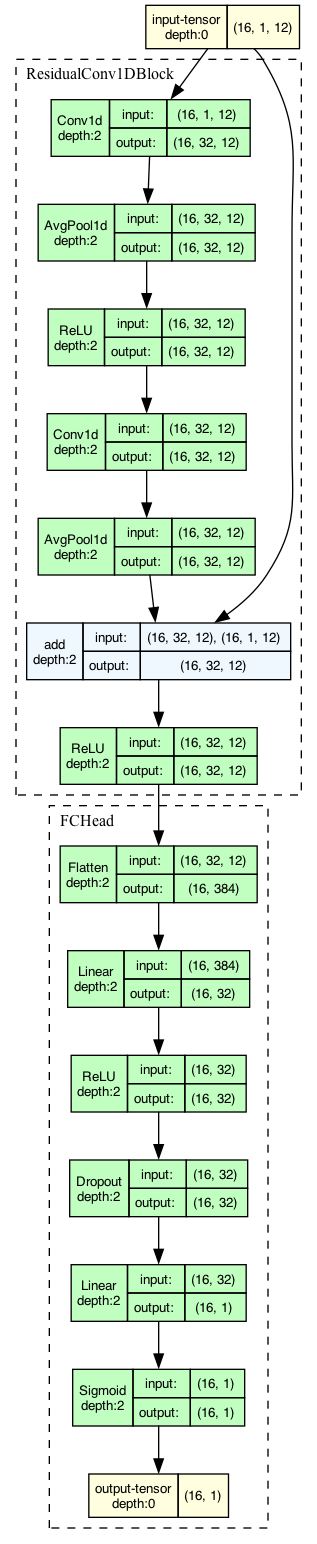

In [36]:
class ResidualConv1DBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(ResidualConv1DBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1)
        self.pooling1 = nn.AvgPool1d(kernel_size=3, padding=1, stride=1)
        # output dimensions of pooling 1d is (n - k + 2p) / s + 1
        self.conv2 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1)
        self.pooling2 = nn.AvgPool1d(kernel_size=3, padding=1, stride=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.conv1(x)
        x1 = self.pooling1(x1)
        x1 = self.relu(x1)
        x1 = self.conv2(x1)
        x1 = self.pooling2(x1)
        x = x1 + x
        x = self.relu(x)
        return x

class FCHead(nn.Module):
    def __init__(self, in_features, dropout_rate=0.5):
        super(FCHead, self).__init__()
        self.fc1 = nn.Linear(in_features=in_features, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=1)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

class Conv1DModel(nn.Module):
    def __init__(self, in_channels):
        super(Conv1DModel, self).__init__()
        self.conv1 = ResidualConv1DBlock(in_channels=in_channels, out_channels=32, kernel_size=3)
        self.head = FCHead(in_features=32*12)

    def forward(self, x):
        x = self.conv1(x)
        x = self.head(x)
        return x

def visualize_model(model):
    graphviz.set_jupyter_format('png')
    model_graph = draw_graph(
        model,
        input_size=(BATCH_SIZE, IN_CHANNELS, SIGNAL_SEQ_LEN),
        device='meta',
        expand_nested=True
    )
    model_graph.resize_graph(scale=1.5)
    return model_graph.visual_graph

visualize_model(Conv1DModel(in_channels=1))

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


# Device selection with MPS support
if torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
elif torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

def prepare_tensors(X_train, y_train, X_val, y_val):
    # Datasets to tensors
    X_train_tensor = torch.tensor(X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1]), dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val.values.reshape(X_val.shape[0], 1, X_val.shape[1]), dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
    X_val_tensor = X_val_tensor.to(DEVICE)
    y_val_tensor = y_val_tensor.to(DEVICE)

    return train_loader, val_loader, X_val_tensor, y_val_tensor

def train_model(model, train_loader, val_loader, plot_loss=False):
    # Move model to device
    model = model.to(DEVICE)
    criterion = nn.BCELoss() # classification problem, nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # For early stopping
    best_val_loss = float('inf')
    patience_counter = 0
    
    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    for epoch in range(NUM_EPOCHS):
        # Training phase
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            # Move batch to appropriate device
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Calculate statistics (move to CPU for numpy operations)
            train_loss += loss.detach().cpu().item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
                outputs = model(inputs).squeeze(1)
                loss = criterion(outputs, labels)                
                val_loss += loss.cpu().item()
                
        
        # Calculate epoch statistics
        epoch_train_loss = train_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)
        
        # Update history
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)

        
            
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}] Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

    if plot_loss:
        plt.plot(history['train_loss'],label='train_loss')
        plt.plot(history['val_loss'],label='valid_loss')
        plt.title('Classification Loss')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    return history

def evaluate_model(model, X_val_tensor, y_val_tensor, target_label):
    global validation_data
    with torch.no_grad():
        model.to(torch.device('cpu'))
        X_val_tensor = X_val_tensor.to(torch.device('cpu'))
        y_val_tensor = y_val_tensor.to(torch.device('cpu'))

        outputs = model(X_val_tensor).squeeze(1)
        y_prob = outputs.view(-1)
        y_pred = (outputs > 0.5).float()

    # Print classification report and ROC AUC
    print_classification_report(y_val_tensor.numpy(), y_pred.numpy(), y_prob.numpy(), f'Conv1D Model {target_label}')

    validation_data['cnn'][target_label] = {
        'y_val': y_val_tensor.numpy(),
        'y_prob': y_prob.numpy(),
    }

    

In [38]:
def train_conv1d_for_label(X_train, y_train, X_val, y_val, label='depression'):
    train_loader, val_loader, X_val_tensor, y_val_tensor = prepare_tensors(X_train, y_train[label], X_val, y_val[label])
    model = Conv1DModel(in_channels=IN_CHANNELS).to(DEVICE)
    history = train_model(model, train_loader, val_loader)
    evaluate_model(model, X_val_tensor, y_val_tensor, target_label=label)
    return model


### Clasificador para depresión

In [39]:
model = train_conv1d_for_label(X_train, y_train, X_val, y_val, label='depression')


Epoch [1/20] Train Loss: 0.6049, Val Loss: 0.5803
Epoch [2/20] Train Loss: 0.5945, Val Loss: 0.5827
Epoch [3/20] Train Loss: 0.5867, Val Loss: 0.5806
Epoch [4/20] Train Loss: 0.5852, Val Loss: 0.5842
Epoch [5/20] Train Loss: 0.5914, Val Loss: 0.5820
Epoch [6/20] Train Loss: 0.5919, Val Loss: 0.5810
Epoch [7/20] Train Loss: 0.5900, Val Loss: 0.5808
Epoch [8/20] Train Loss: 0.5888, Val Loss: 0.5879
Epoch [9/20] Train Loss: 0.5862, Val Loss: 0.5810
Epoch [10/20] Train Loss: 0.5929, Val Loss: 0.5901
Epoch [11/20] Train Loss: 0.5989, Val Loss: 0.5808
Epoch [12/20] Train Loss: 0.5914, Val Loss: 0.5889
Epoch [13/20] Train Loss: 0.5825, Val Loss: 0.5841
Epoch [14/20] Train Loss: 0.5810, Val Loss: 0.5820
Epoch [15/20] Train Loss: 0.5747, Val Loss: 0.5814
Epoch [16/20] Train Loss: 0.5802, Val Loss: 0.5925
Epoch [17/20] Train Loss: 0.5831, Val Loss: 0.5849
Epoch [18/20] Train Loss: 0.5854, Val Loss: 0.5877
Epoch [19/20] Train Loss: 0.5832, Val Loss: 0.5905
Epoch [20/20] Train Loss: 0.5826, Val Lo

### Clasificador para ansiedad

In [40]:
model = train_conv1d_for_label(X_train, y_train, X_val, y_val, label='anxiety')


Epoch [1/20] Train Loss: 0.6866, Val Loss: 0.6839
Epoch [2/20] Train Loss: 0.6888, Val Loss: 0.6835
Epoch [3/20] Train Loss: 0.6837, Val Loss: 0.6833
Epoch [4/20] Train Loss: 0.6862, Val Loss: 0.6835
Epoch [5/20] Train Loss: 0.6851, Val Loss: 0.6831
Epoch [6/20] Train Loss: 0.6842, Val Loss: 0.6827
Epoch [7/20] Train Loss: 0.6823, Val Loss: 0.6831
Epoch [8/20] Train Loss: 0.6867, Val Loss: 0.6831
Epoch [9/20] Train Loss: 0.6876, Val Loss: 0.6837
Epoch [10/20] Train Loss: 0.6850, Val Loss: 0.6839
Epoch [11/20] Train Loss: 0.6853, Val Loss: 0.6831
Epoch [12/20] Train Loss: 0.6854, Val Loss: 0.6826
Epoch [13/20] Train Loss: 0.6877, Val Loss: 0.6838
Epoch [14/20] Train Loss: 0.6860, Val Loss: 0.6843
Epoch [15/20] Train Loss: 0.6850, Val Loss: 0.6831
Epoch [16/20] Train Loss: 0.6838, Val Loss: 0.6827
Epoch [17/20] Train Loss: 0.6841, Val Loss: 0.6838
Epoch [18/20] Train Loss: 0.6847, Val Loss: 0.6840
Epoch [19/20] Train Loss: 0.6851, Val Loss: 0.6835
Epoch [20/20] Train Loss: 0.6832, Val Lo

### Clasificador para stress

In [41]:
model = train_conv1d_for_label(X_train, y_train, X_val, y_val, label='stress')


Epoch [1/20] Train Loss: 0.6870, Val Loss: 0.6844
Epoch [2/20] Train Loss: 0.6860, Val Loss: 0.6850
Epoch [3/20] Train Loss: 0.6888, Val Loss: 0.6849
Epoch [4/20] Train Loss: 0.6857, Val Loss: 0.6854
Epoch [5/20] Train Loss: 0.6855, Val Loss: 0.6843
Epoch [6/20] Train Loss: 0.6865, Val Loss: 0.6847
Epoch [7/20] Train Loss: 0.6875, Val Loss: 0.6850
Epoch [8/20] Train Loss: 0.6838, Val Loss: 0.6853
Epoch [9/20] Train Loss: 0.6851, Val Loss: 0.6845
Epoch [10/20] Train Loss: 0.6865, Val Loss: 0.6845
Epoch [11/20] Train Loss: 0.6860, Val Loss: 0.6849
Epoch [12/20] Train Loss: 0.6865, Val Loss: 0.6848
Epoch [13/20] Train Loss: 0.6847, Val Loss: 0.6849
Epoch [14/20] Train Loss: 0.6857, Val Loss: 0.6850
Epoch [15/20] Train Loss: 0.6857, Val Loss: 0.6843
Epoch [16/20] Train Loss: 0.6839, Val Loss: 0.6843
Epoch [17/20] Train Loss: 0.6840, Val Loss: 0.6843
Epoch [18/20] Train Loss: 0.6852, Val Loss: 0.6844
Epoch [19/20] Train Loss: 0.6859, Val Loss: 0.6840
Epoch [20/20] Train Loss: 0.6838, Val Lo

# Graficas de la curva ROC y DET

#### Graficas de la curva ROC y DET de modelos con etiqueta de “Depression”

In [42]:
import copy
val_data = copy.deepcopy(validation_data)

In [46]:
def plot_roc_auc_for_all_models(data, target_label='depression'):
    plt.figure(figsize=(14, 6))
    palette = sns.color_palette("husl", len(val_data.keys()))

    for i, (name, model_val_data) in enumerate(val_data.items()):
        y_prob = model_val_data['depression']['y_prob']
        y_val = model_val_data['depression']['y_val']

        fpr, tpr, _ = roc_curve(y_val, y_prob)
        fpr_det, fnr_det, _ = det_curve(y_val, y_prob)

        plt.subplot(1, 2, 1)
        sns.lineplot(x=fpr, y=tpr, label=f"{name} (AUC = {roc_auc_score(y_val, y_prob):.2f})",
                    color=palette[i])

        plt.subplot(1, 2, 2)
        sns.lineplot(x=fpr_det, y=fnr_det, label=name, color=palette[i])

    plt.subplot(1, 2, 1)
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", alpha=0.7)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison for {}".format(target_label))
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("False Negative Rate")
    plt.title("DET Curve Comparison for {}".format(target_label))
    plt.legend()

    plt.tight_layout()
    plt.show()


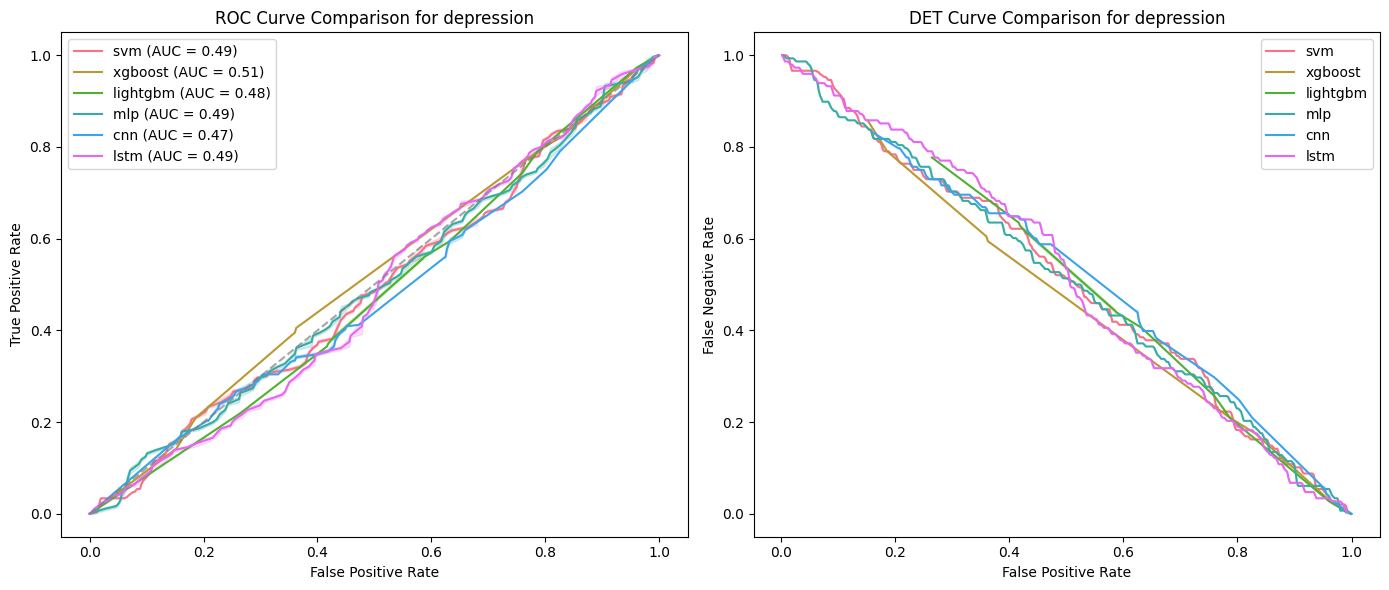

In [47]:
plot_roc_auc_for_all_models(val_data, target_label='depression')

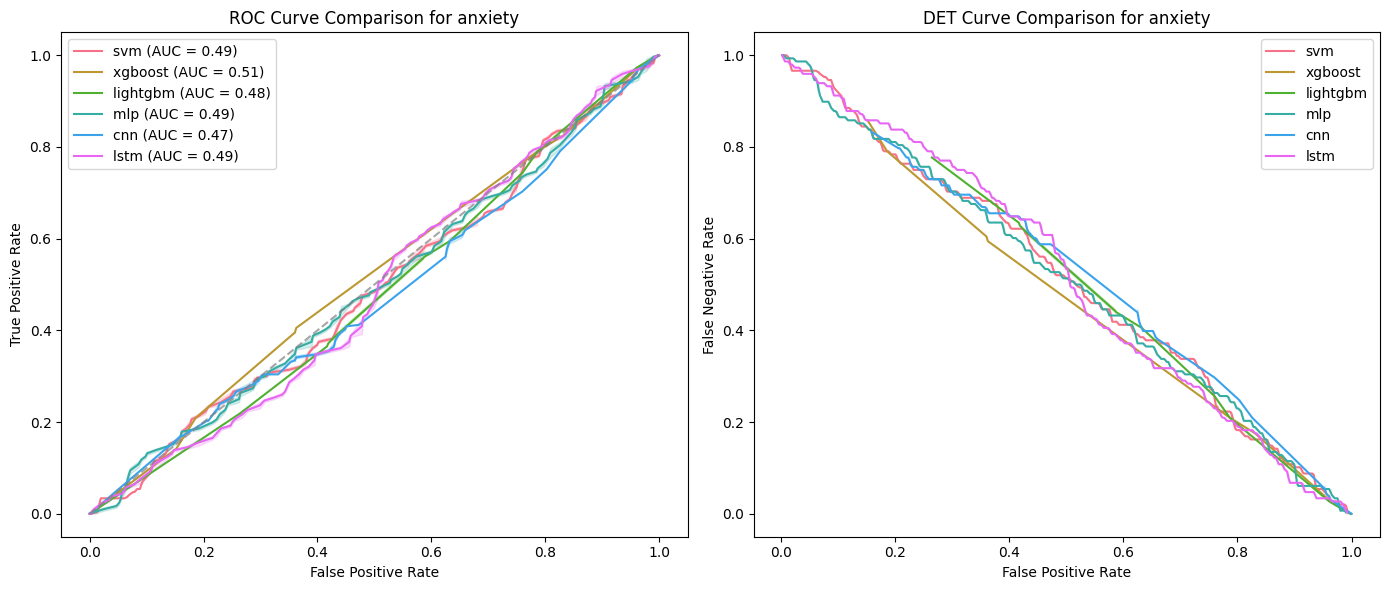

In [48]:
plot_roc_auc_for_all_models(val_data, target_label='anxiety')

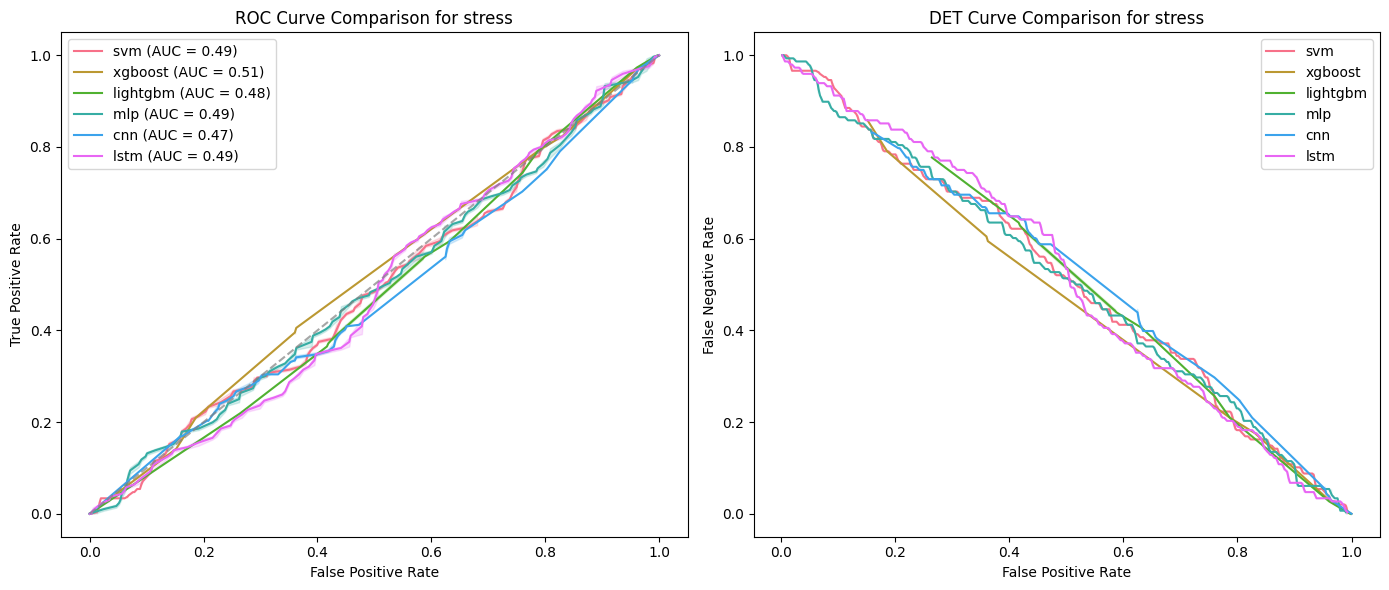

In [49]:
plot_roc_auc_for_all_models(val_data, target_label='stress')

Perspectivas de la curva ROC:

Puntuaciones AUC (0,49–0,51): los modelos funcionan sólo ligeramente mejor que las conjeturas aleatorias, lo que indica una falta de características predictivas sólidas.

Rendimiento consistente en todos los modelos: ningún modelo supera significativamente a los demás

Información sobre la curva DET:

Las curvas DET muestran que las mejoras en FPR no mejoran drásticamente la FNR, lo que sugiere que los modelos están luchando con límites de decisión claros.


Guardamos la lista de la etiqueta “depression” para la siguiente sección.

Perspectivas de la curva ROC:

AUC similar a la ansiedad (~0,50–0,51): los modelos funcionan ligeramente mejor que las conjeturas aleatorias, pero aún carecen de un fuerte poder predictivo.

No hay un modelo destacado: a diferencia de la ansiedad, donde los modelos basados en árboles mejoraron ligeramente los resultados, todos los modelos parecen funcionar de manera similar para la detección del estrés.

Regresión logística y SVM bajan ligeramente en rendimiento.

Información sobre la curva DET:

Posible limitación del conjunto de datos: si ningún modelo mejora significativamente los resultados, es posible que las funciones no capturen patrones relacionados con el estrés de manera efectiva.


# Ajuste de Hiperparámetros de los mejores dos modelos

# Selección del mejor modelo


# Conclusiones

Lorem ipsum

# Referencias

S, G., Anand, A., Vijayvargiya, A., M, P., Moorthy, V., Kumar, S., & S, H. B. S. (2022, July 12). Emosens: Emotion recognition based on sensor data analysis using LIGHTGBM. arXiv.org. https://arxiv.org/abs/2207.14640

Costa, R. (2022). The CRISP-ML Methodology: A Step-by-Step Approach to Real-World Machine Learning Projects.

Piccini, N. (2023, julio 19). 101 machine learning algorithms for data science with cheat sheets. Data Science Dojo.